In [1]:
using Pkg
Pkg.activate(".")
#Pkg.instantiate()

  Activating project at `~/Documents/UCL/3x2_analytical`


In [2]:
using LinearAlgebra
using LimberJack
using CSV
using YAML
using JLD2
using PythonCall
using DataFrames
using NPZ
using Plots
sacc = pyimport("sacc");

In [3]:
method = "bpz"
sacc_path = "data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "data/CosmoDC2/wlwl.yml"
nz_path = string("data/CosmoDC2/image_nzs_", method, "_priors/")
fake_data_path = string("data/CosmoDC2/CosmoDC2_wlwl_theory_photo_", method, "_best.csv")

fake_data = CSV.read(fake_data_path, DataFrame)
fake_data = fake_data.theory[1:end-1]

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))

meta_wlwl, files_wlwl = make_data(sacc_file, yaml_file;
                        nz_source_0=nz_source_0,
                        nz_source_1=nz_source_1,
                        nz_source_2=nz_source_2,
                        nz_source_3=nz_source_3,
                        nz_source_4=nz_source_4)

meta_wlwl.types = [
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

source_0 source_0 15
source_1 source_0 15
source_1 source_1 15
source_2 source_0 15
source_2 source_1 15
source_2 source_2 15
source_3 source_0 15
source_3 source_1 15
source_3 source_2 15
source_3 source_3 15
source_4 source_0 15
source_4 source_1 15
source_4 source_2 15
source_4 source_3 15
source_4 source_4 15
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_source_4


5-element Vector{String}:
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

In [4]:
using Interpolations
using Statistics

In [5]:
dz = mean(nz_source_0["z"][2:end] - nz_source_0["z"][1:end-1])
z0 = nz_source_0["z"][1]:dz:nz_source_0["z"][end]
println(Vector(z0))
nzi = cubic_spline_interpolation(z0, nz_source_0["dndz"])
z00 = nz_source_0["z"][1]:0.01:nz_source_0["z"][end]

[0.04, 0.12, 0.2, 0.28, 0.36, 0.44, 0.52, 0.6, 0.68, 0.76, 0.84, 0.92, 1.0, 1.08, 1.16, 1.24, 1.32, 1.4, 1.48, 1.56, 1.64, 1.72, 1.8, 1.88, 1.96]


0.04:0.01:1.96

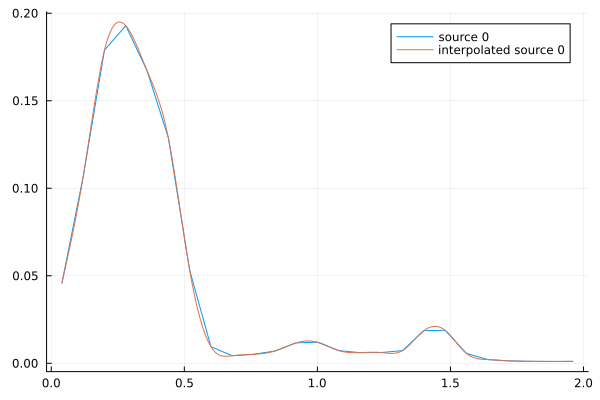

In [6]:
plot(nz_source_0["z"], nz_source_0["dndz"], label="source 0")
plot!(z00, nzi.(z00), label="interpolated source 0")

In [7]:
method = "bpz"
sacc_path = "data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "data/CosmoDC2/gcgc.yml"
nz_path = string("data/CosmoDC2/image_nzs_", method, "_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))

meta_gcgc, files_gcgc = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4)

meta_gcgc.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density"]


lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


5-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"

In [8]:
method = "bpz"
sacc_path = "data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "data/CosmoDC2/gcgc_gcwl_wlwl.yml"
nz_path = string("data/CosmoDC2/image_nzs_", method, "_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))

meta_3x2, files_3x2 = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4,
                        nz_source_0=nz_source_0,
                        nz_source_1=nz_source_1,
                        nz_source_2=nz_source_2,
                        nz_source_3=nz_source_3,
                        nz_source_4=nz_source_4)

meta_3x2.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
source_0 lens_0 6
source_0 lens_1 7
source_0 lens_2 8
source_0 lens_3 9
source_0 lens_4 9
source_1 lens_0 8
source_1 lens_1 7
source_1 lens_2 8
source_1 lens_3 9
source_1 lens_4 9
source_2 lens_0 8
source_2 lens_1 7
source_2 lens_2 8
source_2 lens_3 9
source_2 lens_4 9
source_3 lens_0 8
source_3 lens_1 7
source_3 lens_2 8
source_3 lens_3 9
source_3 lens_4 9
source_4 lens_0 8
source_4 lens_1 7
source_4 lens_2 8
source_4 lens_3 9
source_4 lens_4 9
source_0 source_0 15
source_1 source_0 15
source_1 source_1 15
source_2 source_0 15
source_2 source_1 15
source_2 source_2 15
source_3 source_0 15
source_3 source_1 15
source_3 source_2 15
source_3 source_3 15
source_4 source_0 15
source_4 source_1 15
source_4 source_2 15
source_4 source_3 15
source_4 source_4 15
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_sour

10-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

### Make Data

In [9]:
function model_wlwl(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
     meta=meta_wlwl, 
     files=files_wlwl,
     data=nothing)
    nuisances = Dict(
        "lens_0_b"    => 0.879118,
        "lens_1_b"    => 1.05894,
        "lens_2_b"    => 1.22145,
        "lens_3_b"    => 1.35065,
        "lens_4_b"    => 1.58909,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118)
    
    cosmology = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    theory = Theory(cosmology, meta, files; Nuisances=nuisances)
    if data == nothing
        data = meta.data
    end
    d = theory .- data
    xi2 = d'*meta.inv_cov*d
    return theory, xi2
end

function model_gcgc(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
     meta=meta_gcgc, 
     files=files_gcgc,
     data=nothing)
    nuisances = Dict(
        "lens_0_b"    => 0.879118,
        "lens_1_b"    => 1.05894,
        "lens_2_b"    => 1.22145,
        "lens_3_b"    => 1.35065,
        "lens_4_b"    => 1.58909,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118)

    cosmology = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit,
        nk=5000)

    theory = Theory(cosmology, meta, files; 
    Nuisances=nuisances,
    int_gc="cubic", res_gc=1000)
    if data == nothing
        data = meta.data
    end
    d = theory .- data
    xi2 = d'*meta.inv_cov*d
    return theory, xi2
end

function model_3x2(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    meta=meta_3x2, 
    files=files_3x2,
    data=nothing)
    nuisances = Dict(
        "lens_0_b"    => 0.879118,
        "lens_1_b"    => 1.05894,
        "lens_2_b"    => 1.22145,
        "lens_3_b"    => 1.35065,
        "lens_4_b"    => 1.58909,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118)

    cosmology = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit,
        nk=5000)

    theory = Theory(cosmology, meta, files; 
        Nuisances=nuisances,
        int_gc="cubic", res_gc=1000)
    if data == nothing
        data = meta.data
    end
    d = theory .- data
    xi2 = d'*meta.inv_cov*d
    return theory, xi2
end

model_3x2 (generic function with 1 method)

In [10]:
t_wlwl, Xi2_wlwl = model_wlwl()
t_gcgc, Xi2_gcgc = model_gcgc()
t_3x2, Xi2_3x2 = model_3x2()
println("Xi2_wlwl = ", Xi2_wlwl)
println("Xi2_gcgc = ", Xi2_gcgc)
println("Xi2_3x2 = ", Xi2_3x2)

Xi2_wlwl = 234.09277309099252
Xi2_gcgc = 699.5850886549154
Xi2_3x2 = 1514.642228563939


In [11]:
npzwrite("data/CosmoDC2/theories.npz", 
    t_wlwl=t_wlwl,
    t_gcgc=t_gcgc,
    t_3x2=t_3x2)

In [12]:
using ForwardDiff

In [13]:
function grad_h(h)
    function f(h)
        t, Xi2 = model_3x2(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=h, ns=0.99651,
            meta=meta_3x2, files=files_3x2, data=t_3x2)
        return Xi2
    end
    return ForwardDiff.derivative(f, h)
end

function grad_Wm(Wm)
    function f(Wm)
        t, Xi2 = model_3x2(;Ωm=Wm, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
            meta=meta_3x2, files=files_3x2, data=t_3x2)
        return Xi2
    end
    return ForwardDiff.derivative(f, Wm)
end

grad_Wm (generic function with 1 method)

In [14]:
Wm = range(0.2, 0.5, length=200)
h = range(0.6, 0.9, length=200)

0.6:0.001507537688442211:0.9

In [15]:
#Wm_grads = [grad_Wm(Wm_i) for Wm_i in Wm]
Wm_xi2_3x2 = [model_3x2(;Ωm=Wm_i, data=t_3x2)[2] for Wm_i in Wm]
Wm_xi2_wlwl = [model_wlwl(;Ωm=Wm_i, data=t_wlwl)[2] for Wm_i in Wm]

200-element Vector{Float64}:
  395.64280506868187
  380.8181262767937
  366.2193099678528
  351.8502659005325
  337.714775367692
  323.81692777903385
  310.1602311551331
  296.7486133363981
  283.5854368764378
  270.6736952850337
  258.0170565555606
  245.61923739655563
  233.48480244267733
    ⋮
 4559.046830252828
 4628.867823846307
 4699.256642410857
 4770.213578503104
 4841.739865149206
 4913.836067951637
 4986.508256785905
 5059.751779179869
 5133.569301140028
 5207.963898301941
 5282.932832644477
 5358.475767057395

In [16]:
#h_grads = [grad_h(h_i) for h_i in h]
h_xi2_3x2 = [model_3x2(;h=h_i, data=t_3x2)[2] for h_i in h]
h_xi2_wlwl = [model_wlwl(;h=h_i, data=t_wlwl)[2] for h_i in h]

200-element Vector{Float64}:
 4.457213411773139
 4.333470849617769
 4.211770240540302
 4.092083319181178
 3.9744903086001138
 3.859241554275346
 3.745490340391834
 3.6340645756343264
 3.5244635396587767
 3.416932787408497
 3.311441681913756
 3.207708042958934
 3.105843018608084
 ⋮
 5.2660839340054615
 5.349932634327271
 5.434510093593985
 5.519495329703941
 5.604794806717343
 5.690713745576936
 5.776960614106107
 5.863300364829048
 5.9501169679870625
 6.037714213784281
 6.125625867449251
 6.213611364540189

In [17]:
Wm_xi2_gcgc = [model_gcgc(;Ωm=Wm_i, data=t_gcgc)[2] for Wm_i in Wm]
h_xi2_gcgc = [model_gcgc(;h=h_i, data=t_gcgc)[2] for h_i in h]

200-element Vector{Float64}:
 83.96676440234174
 80.76470171364689
 77.62944426614763
 74.5787791277788
 71.56963602567285
 68.63359743481888
 66.47683740886937
 63.64376187399419
 64.57749503130121
 63.30295874316865
 60.518107297561905
 57.82051409917881
 55.166896003074044
  ⋮
 75.41310732411957
 77.6520235819998
 76.80077637286679
 79.49270913121869
 79.17019623065285
 80.91656251340633
 83.22419101388947
 82.36955718705693
 85.14249741804636
 84.82359507496145
 86.62785308232976
 89.10596264336701

In [18]:
#plot(h, h_grads, label="grad_h")

In [19]:
#plot(Wm, Wm_grads, label="grad_Wm")

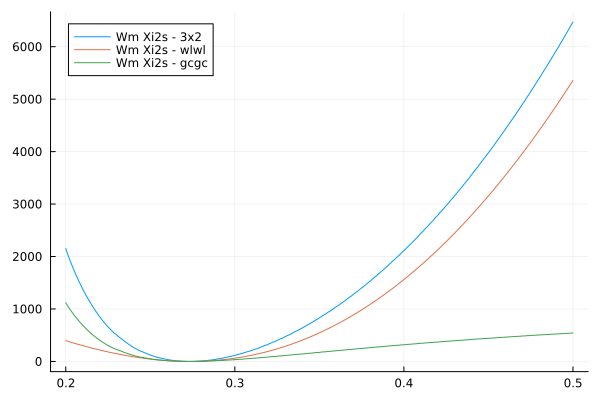

In [20]:
plot(Wm, Wm_xi2_3x2, label="Wm Xi2s - 3x2")
plot!(Wm, Wm_xi2_wlwl, label="Wm Xi2s - wlwl")
plot!(Wm, Wm_xi2_gcgc, label="Wm Xi2s - gcgc")

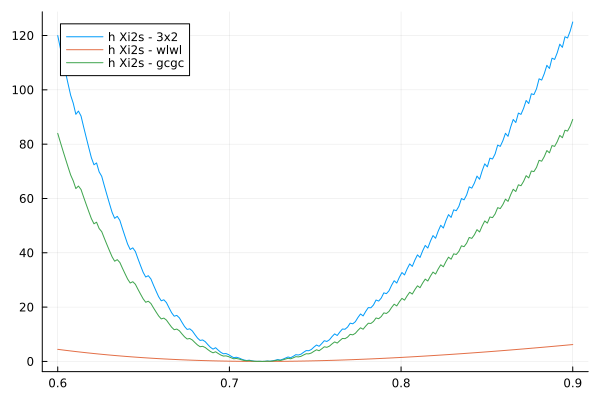

In [21]:
plot(h, h_xi2_3x2, label="h Xi2s - 3x2")
plot!(h, h_xi2_wlwl, label="h Xi2s - wlwl")
plot!(h, h_xi2_gcgc, label="h Xi2s - gcgc")